# Position and rotation estimation

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU

## Preparing data 

In [2]:
DATADIR = "dataset_generator/images/"
JSON_file_name = "data.txt"
IMAGES = 1_000
OG_IMG_SIZE = 800
IMG_SIZE = 150

In [3]:
data_json = []
for line in open(DATADIR + JSON_file_name, 'r'):
    data_json.append(json.loads(line))
    
dataset = [] # [x, y]

for img in os.listdir(DATADIR):
    if(img.endswith(".jpg")):
        img_array = cv2.imread(os.path.join(DATADIR, img), cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        img_index = int(img.strip(".jpg"))
        for label in data_json:
            if(label['index'] == img_index):
                choosen_label = {'bx': label['bx'], 
                                 'by': label['by'], 
                                 'bw': label['bw'], 
                                 'bh': label['bh'], 
                                 'posX': label['posX'], 
                                 'posY': label['posY'], 
                                 'posZ': label['posZ']}
                
                xy = [img_array, choosen_label]
                dataset.append(xy)
                
        if(len(dataset)%500 ==0):
            print(f"{len(dataset)} images loaded")
        
        if(len(dataset) >= IMAGES):
            print("All images loaded")
            break
            
IMAGES = len(dataset)
print(f"{IMAGES} in total")

500 images loaded
1000 images loaded
All images loaded
1000 in total


## Training dataset

X shape: (1000, 150, 150, 1)
y shape: (1000, 7)


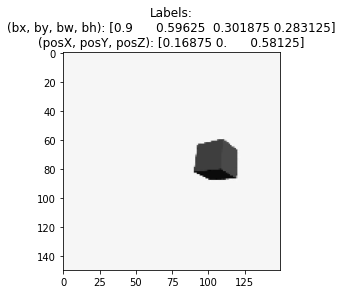

In [4]:
X = []
y = []

shuffled_indices = random.sample(range(0, IMAGES), IMAGES)

for i in shuffled_indices:
    X.append(dataset[i][0])
    
    y_labels = [dataset[i][1]['bx'], 
                dataset[i][1]['by'], 
                dataset[i][1]['bw'], 
                dataset[i][1]['bh'], 
                dataset[i][1]['posX'], 
                dataset[i][1]['posY'], 
                dataset[i][1]['posZ']]
    
    y_labels = [y_corrected * (IMG_SIZE / OG_IMG_SIZE) for y_corrected in y_labels]
    y.append(y_labels)

# Global Standardization
X = (np.array(X).reshape(IMAGES, IMG_SIZE, IMG_SIZE, 1) - np.mean(X)) / np.std(X)
    
for index, ya in enumerate(y):
    y[index] = np.array([ya[0]/100, ya[1]/100, ya[2]/100, ya[3]/100, ya[4]/10, ya[5]/10, ya[6]/10])
    
y = np.array(y)

print(f"X shape: {X.shape}\ny shape: {y.shape}")

random_index = random.randrange(IMAGES)

plt.title(f"Labels:\n(bx, by, bw, bh): {y[random_index][:4]}\n(posX, posY, posZ): {y[random_index][4:7]}")
plt.imshow(X[random_index], cmap="gray")
plt.show()

# Building model

## Main stream

In [5]:
inputs = Input(name="Inputs", 
               shape = (IMG_SIZE, IMG_SIZE, 1))

mainStream = Conv2D(name="main_stream_conv_1",
           filters = 16,
           kernel_size = 7,
           strides=1,
           padding="same",
           kernel_initializer=tf.keras.initializers.GlorotUniform())(inputs)

mainStream = LeakyReLU()(mainStream)

mainStream = Conv2D(name="main_stream_conv_2",
           filters = 16,
           kernel_size = 5,
           strides=1,
           padding="same",
           kernel_initializer=tf.keras.initializers.GlorotUniform())(mainStream)

mainStream = LeakyReLU()(mainStream)

mainStream = Conv2D(name="main_stream_conv_3",
           filters = 16,
           kernel_size = 5,
           strides=1,
           padding="same",
           kernel_initializer=tf.keras.initializers.GlorotUniform())(mainStream)

mainStream = LeakyReLU()(mainStream)

mainStream = Conv2D(name="main_stream_conv_4",
           filters = 16,
           kernel_size = 3,
           strides=1,
           padding="same",
           kernel_initializer=tf.keras.initializers.GlorotUniform())(mainStream)

mainStream = LeakyReLU()(mainStream)

## Bounding boxes stream

In [6]:
boundingStream = MaxPooling2D(name="bounding_stream_MaxPooling_1",pool_size = (3, 3))(mainStream)

boundingStream = Conv2D(name="bounding_stream_conv_1",
           filters = 16,
           kernel_size = 3,
           strides=1,
           padding="same",
           kernel_initializer=tf.keras.initializers.GlorotUniform())(boundingStream)

boundingStream = LeakyReLU()(boundingStream)

boundingStream = MaxPooling2D(name="bounding_stream_MaxPooling_2",pool_size = (3, 3))(boundingStream)

boundingStream = Flatten()(boundingStream)

boundingStream = Dense(20, activation="relu")(boundingStream)
boundingStream = Dense(20, activation="relu")(boundingStream)
boundingStream = Dense(10, activation="relu")(boundingStream)
boundingStream = Dense(4, activation="relu", name="boundingPipeOutput")(boundingStream)

# Position stream

In [7]:
positionStream = Conv2D(name="position_stream_conv_1",
           filters = 32,
           kernel_size = 5,
           strides=1,
           padding="same",
           kernel_initializer=tf.keras.initializers.GlorotUniform())(mainStream)

positionStream = layers.LeakyReLU()(positionStream)

positionStream = MaxPooling2D(name="position_stream_MaxPooling_1",pool_size = (2, 2))(positionStream)

positionStream = Conv2D(name="position_stream_conv_2",
           filters = 32,
           kernel_size = 3,
           strides=1,
           padding="same",
           kernel_initializer=tf.keras.initializers.GlorotUniform())(positionStream)

positionStream = layers.LeakyReLU()(positionStream)

positionStream = MaxPooling2D(name="position_stream_MaxPooling_2",pool_size = (2, 2))(positionStream)

positionStream = Flatten()(positionStream)

positionStream = Dense(20, activation="relu")(positionStream)
positionStream = Dense(20)(positionStream)
positionStream = Dense(3, name="positionPipeOutput")(positionStream)

## Assembly

Model: "Sliding_windows_CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
main_stream_conv_1 (Conv2D)     (None, 150, 150, 16) 800         Inputs[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 150, 150, 16) 0           main_stream_conv_1[0][0]         
__________________________________________________________________________________________________
main_stream_conv_2 (Conv2D)     (None, 150, 150, 16) 6416        leaky_re_lu[0][0]                
________________________________________________________________________________

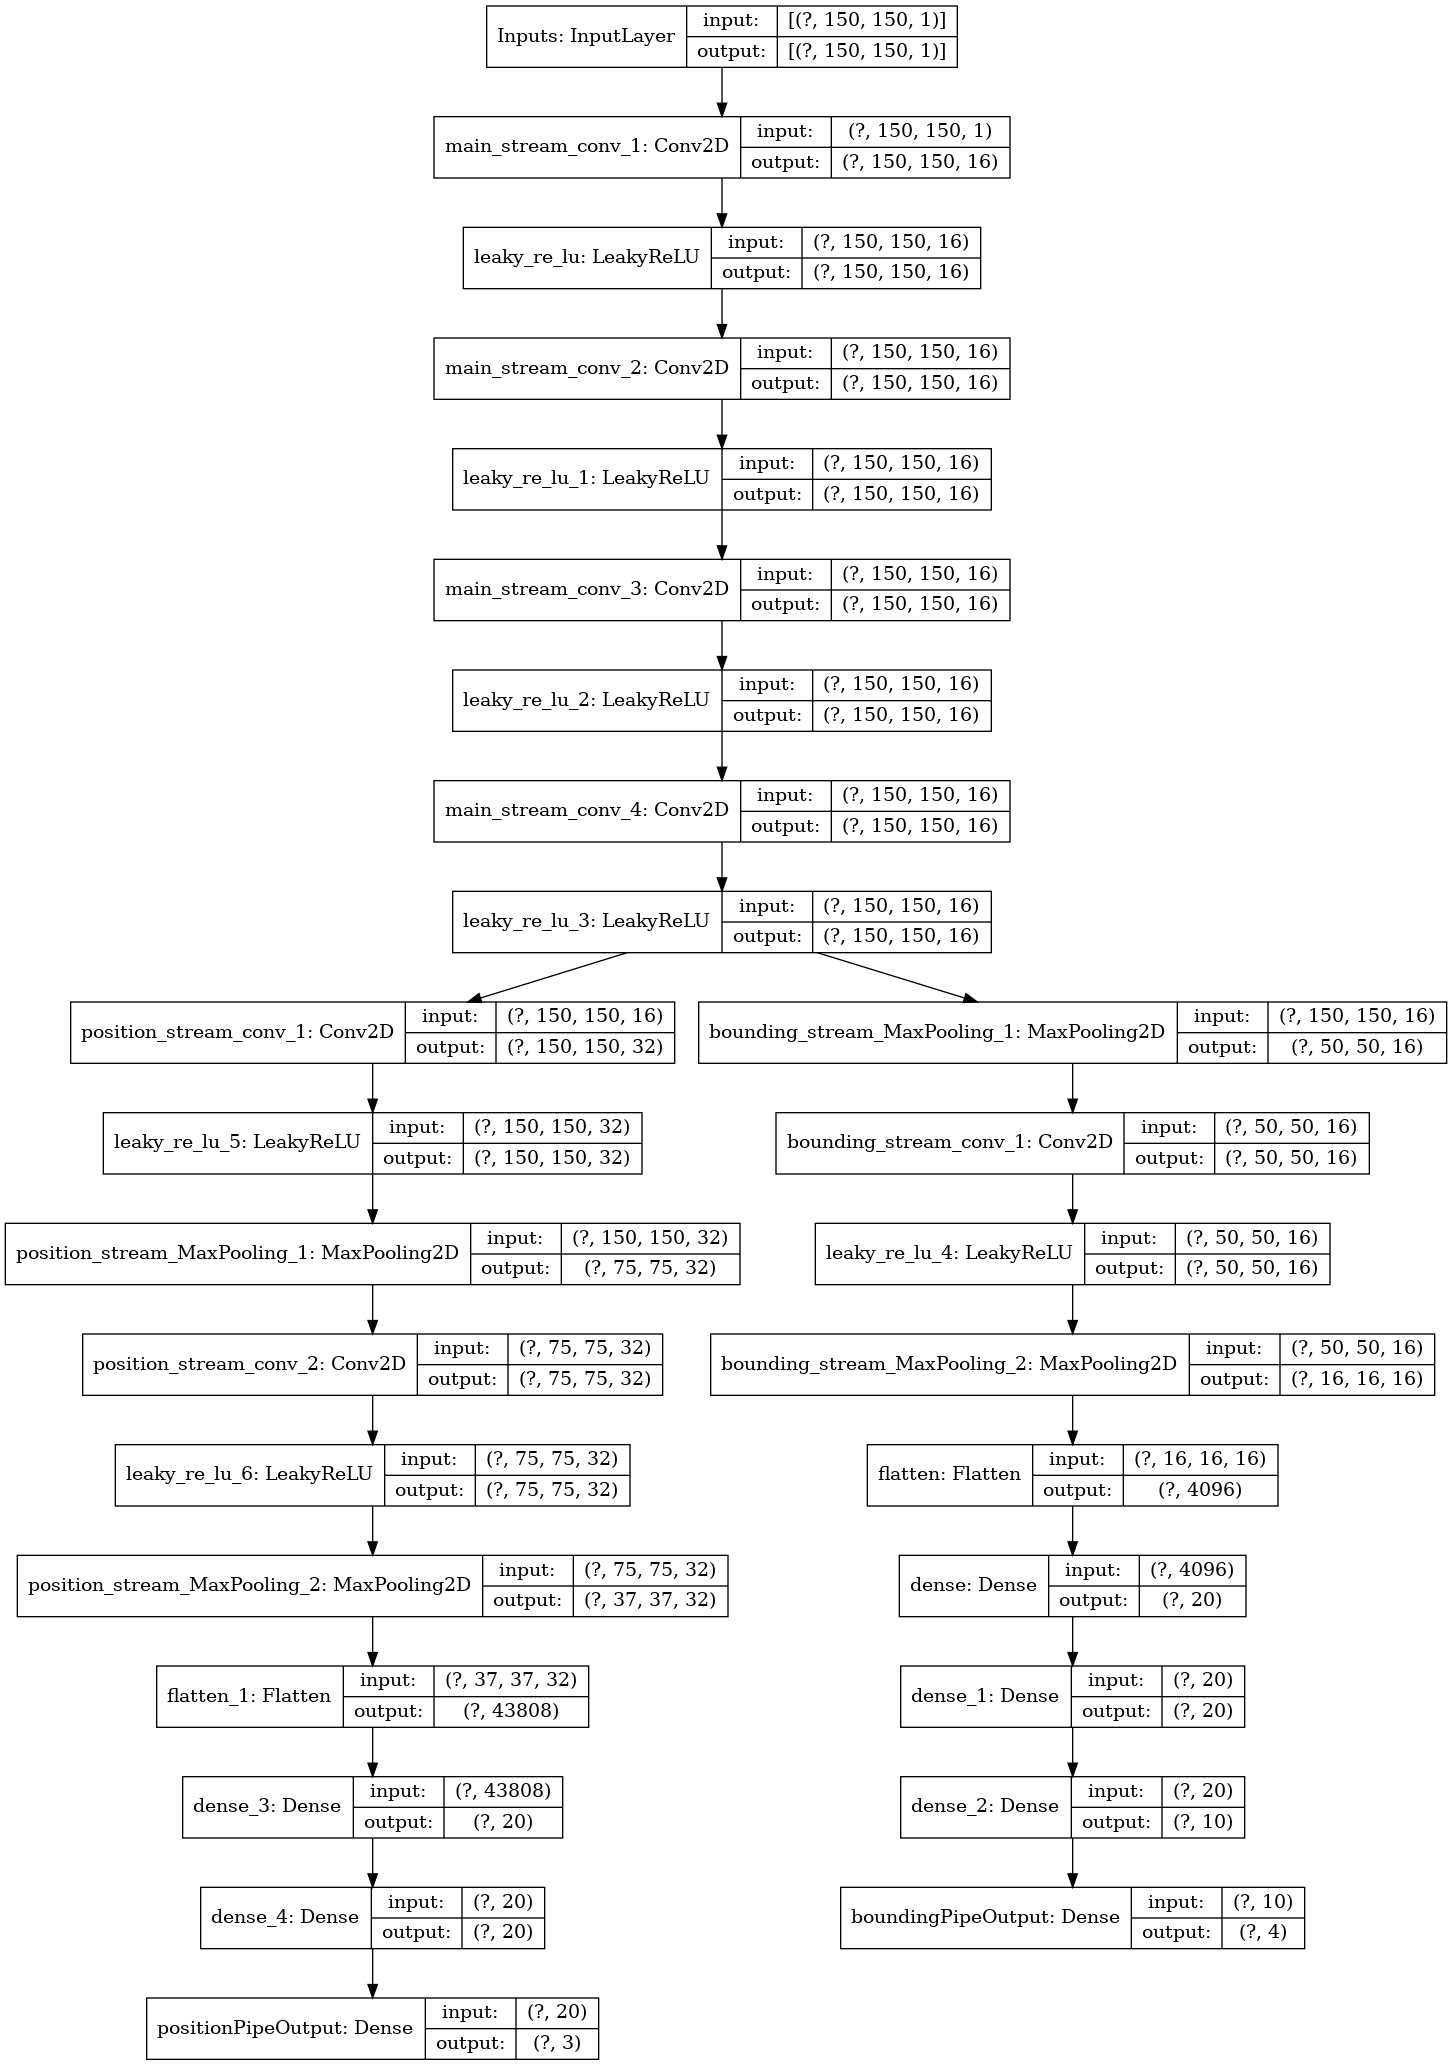

In [8]:
model = keras.Model(inputs, [boundingStream, positionStream], name="Sliding_windows_CNN")

model_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    amsgrad=False)

model_loss = tf.keras.losses.MeanSquaredError()

model.compile(optimizer = model_optimizer,
              loss = model_loss, 
              metrics = ["accuracy"]) 
# #######
# # 95% #
# #######

# model = keras.Model(inputs, [boundingStream, positionStream], name="Sliding_windows_CNN")

# model_optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.005,
#     beta_1=0.9,
#     amsgrad=False)

# model_loss = tf.keras.losses.MeanSquaredError()

# model.compile(optimizer = model_optimizer,
#               loss = model_loss, 
#               metrics = ["accuracy"])

model.summary()
keras.utils.plot_model(model, "pos_rot_est_model.png", show_shapes=True)

# Training

In [9]:
boundingPipeOutputData = y[:, 0:4]
positionPipeOutputData = y[:, 4:7]

history = model.fit(x = X,
                    y = {"boundingPipeOutput": boundingPipeOutputData, "positionPipeOutput": positionPipeOutputData}, 
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.2)

Epoch 1/10
25/25 [==============================] - 60s 2s/step - loss: 0.1323 - boundingPipeOutput_loss: 0.0809 - positionPipeOutput_loss: 0.0514 - boundingPipeOutput_accuracy: 0.8163 - positionPipeOutput_accuracy: 0.9450 - val_loss: 0.0569 - val_boundingPipeOutput_loss: 0.0489 - val_positionPipeOutput_loss: 0.0079 - val_boundingPipeOutput_accuracy: 0.8650 - val_positionPipeOutput_accuracy: 0.9800
Epoch 2/10
25/25 [==============================] - 58s 2s/step - loss: 0.0497 - boundingPipeOutput_loss: 0.0447 - positionPipeOutput_loss: 0.0051 - boundingPipeOutput_accuracy: 0.8512 - positionPipeOutput_accuracy: 0.9837 - val_loss: 0.0444 - val_boundingPipeOutput_loss: 0.0405 - val_positionPipeOutput_loss: 0.0040 - val_boundingPipeOutput_accuracy: 0.8500 - val_positionPipeOutput_accuracy: 0.9800
Epoch 3/10
25/25 [==============================] - 57s 2s/step - loss: 0.0402 - boundingPipeOutput_loss: 0.0373 - positionPipeOutput_loss: 0.0029 - boundingPipeOutput_accuracy: 0.8438 - positionP

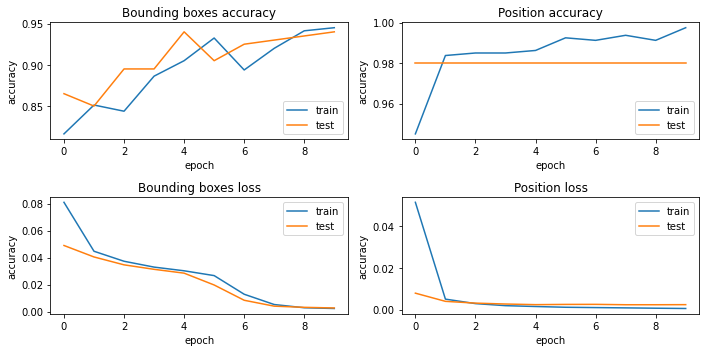

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
    
axs[0, 0].set_title('Bounding boxes accuracy')
axs[0, 0].set_ylabel('accuracy')
axs[0, 0].set_xlabel('epoch')
axs[0, 0].plot(history.history['boundingPipeOutput_accuracy'], label = "train")
axs[0, 0].plot(history.history['val_boundingPipeOutput_accuracy'], label = "test")
axs[0, 0].legend(loc='lower right')

axs[0, 1].set_title('Position accuracy')
axs[0, 1].set_ylabel('accuracy')
axs[0, 1].set_xlabel('epoch')
axs[0, 1].plot(history.history['positionPipeOutput_accuracy'], label = "train")
axs[0, 1].plot(history.history['val_positionPipeOutput_accuracy'], label = "test")
axs[0, 1].legend(loc='lower right')

axs[1, 1].set_title('Position loss')
axs[1, 1].set_ylabel('accuracy')
axs[1, 1].set_xlabel('epoch')
axs[1, 1].plot(history.history['positionPipeOutput_loss'], label = "train")
axs[1, 1].plot(history.history['val_positionPipeOutput_loss'], label = "test")
axs[1, 1].legend(loc='upper right')

axs[1, 0].set_title('Bounding boxes loss')
axs[1, 0].set_ylabel('accuracy')
axs[1, 0].set_xlabel('epoch')
axs[1, 0].plot(history.history['boundingPipeOutput_loss'], label = "train")
axs[1, 0].plot(history.history['val_boundingPipeOutput_loss'], label = "test")
axs[1, 0].legend(loc='upper right')

plt.tight_layout()


# Results

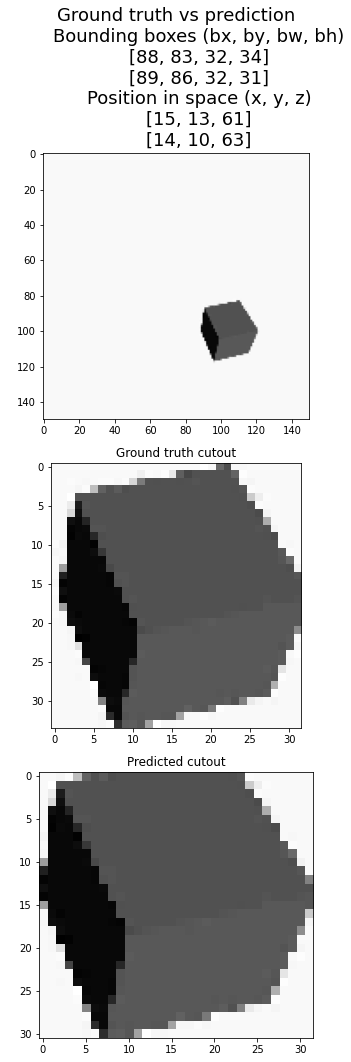

In [12]:
random_index = random.randrange(IMAGES)
prediction = model.predict(X[random_index].reshape(1, IMG_SIZE, IMG_SIZE, 1))

ground_truth = [int(p*100) for p in y[random_index]]
predicted_boxes = [int(p*100) for p in prediction[0][0]]
predicted_pos = [int(p*100) for p in prediction[1][0]]

fig, axs = plt.subplots(3, 1, figsize=(15,15))
results_str = f"Ground truth vs prediction\n\
        Bounding boxes (bx, by, bw, bh)\n\
        {ground_truth[:4]}\n\
        {predicted_boxes}\n\
        Position in space (x, y, z)\n\
        {ground_truth[4:7]}\n\
        {predicted_pos}"
fig.suptitle(results_str , fontsize=18)

axs[0].imshow(X[random_index], cmap="gray")

ground_truth_cutout = X[random_index][ground_truth[1]:ground_truth[1] + ground_truth[3], 
                                      ground_truth[0]:ground_truth[0] + ground_truth[2]]

axs[1].set_title("Ground truth cutout")
axs[1].imshow(ground_truth_cutout, cmap="gray")

predicted_cutout = X[random_index][predicted_boxes[1]:predicted_boxes[1] + predicted_boxes[3], 
                                      predicted_boxes[0]:predicted_boxes[0] + predicted_boxes[2]]

axs[2].set_title("Predicted cutout")
axs[2].imshow(predicted_cutout, cmap="gray")

plt.tight_layout()

# Feature extraction

In [13]:
def extract_layer_data(layer_name):
    intermediate_layer_model = keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    
    intermediate_layer_output = intermediate_layer_model.predict(np.array(X[random_index]).reshape(1, IMG_SIZE, IMG_SIZE, 1))
    
    channels = intermediate_layer_output.shape[-1]
    filterNumber = 0
    fig, axs = plt.subplots(4, 4, figsize=(15,15))
    for col in range(0, 4):
        for row in range(0, 4):
            axs[col, row].imshow(intermediate_layer_output[0, :, :, filterNumber])
            filterNumber += 1
    
    fig.suptitle(f"{layer_name} output", fontsize = 24)
    plt.tight_layout()

## Main stream

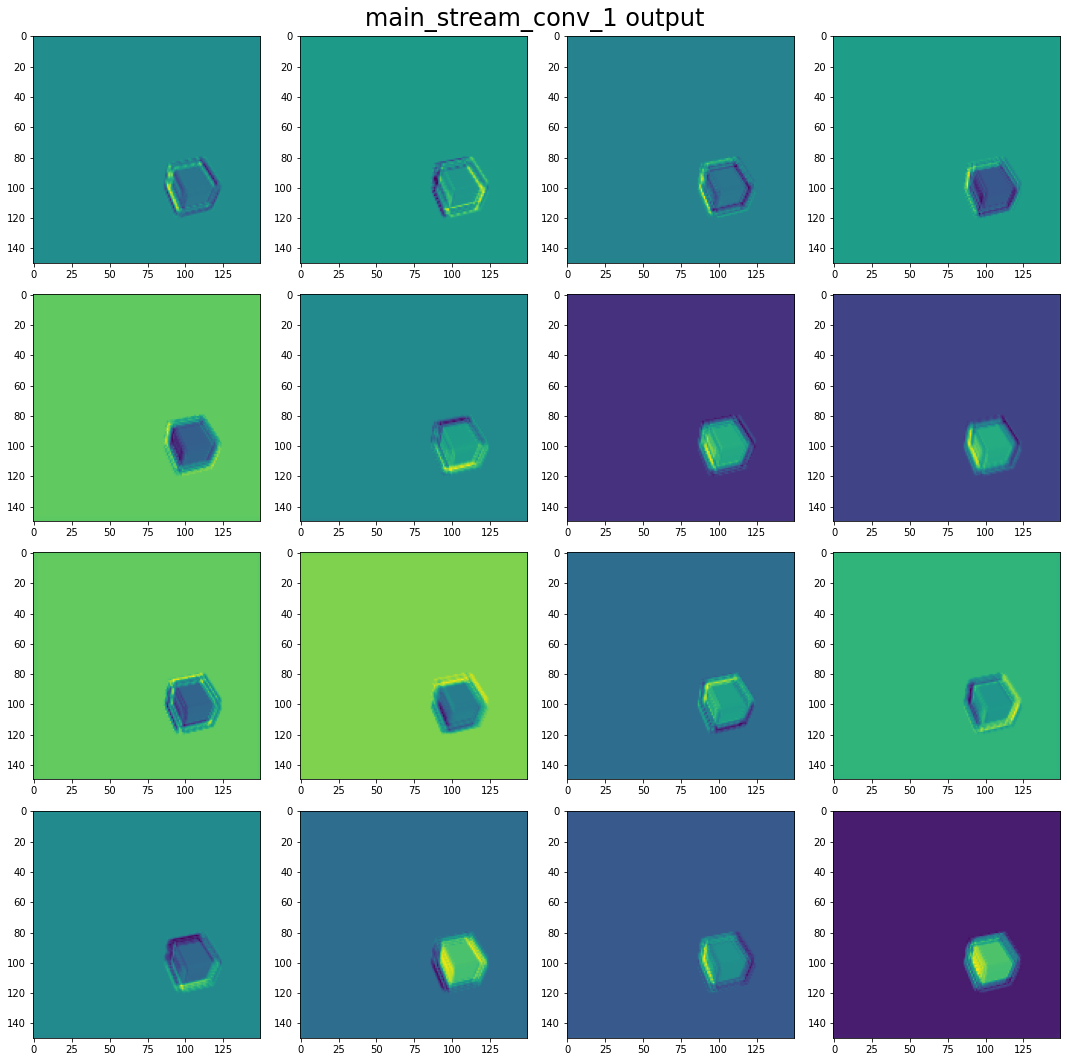

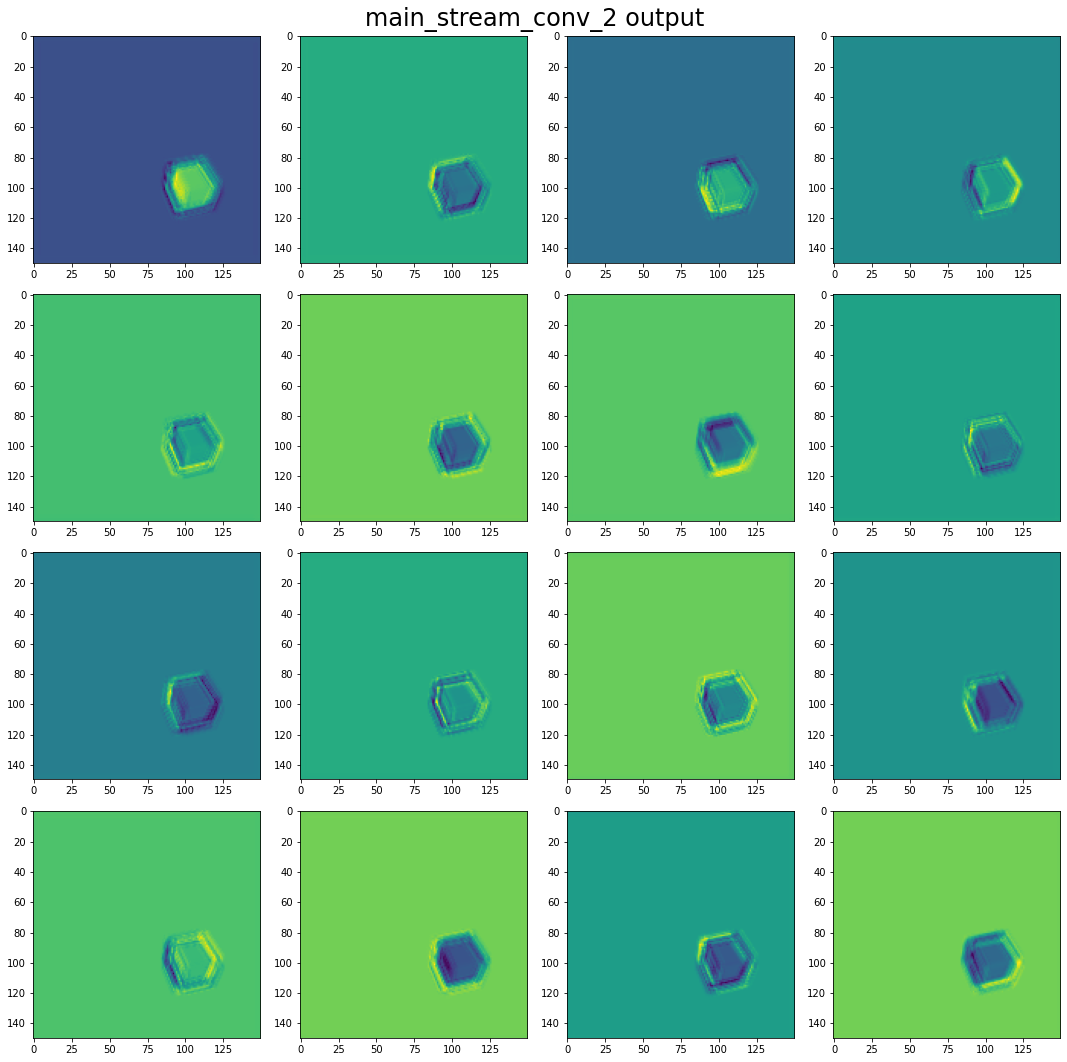

In [14]:
extract_layer_data("main_stream_conv_1")
extract_layer_data("main_stream_conv_2")

## Bounding boxes stream

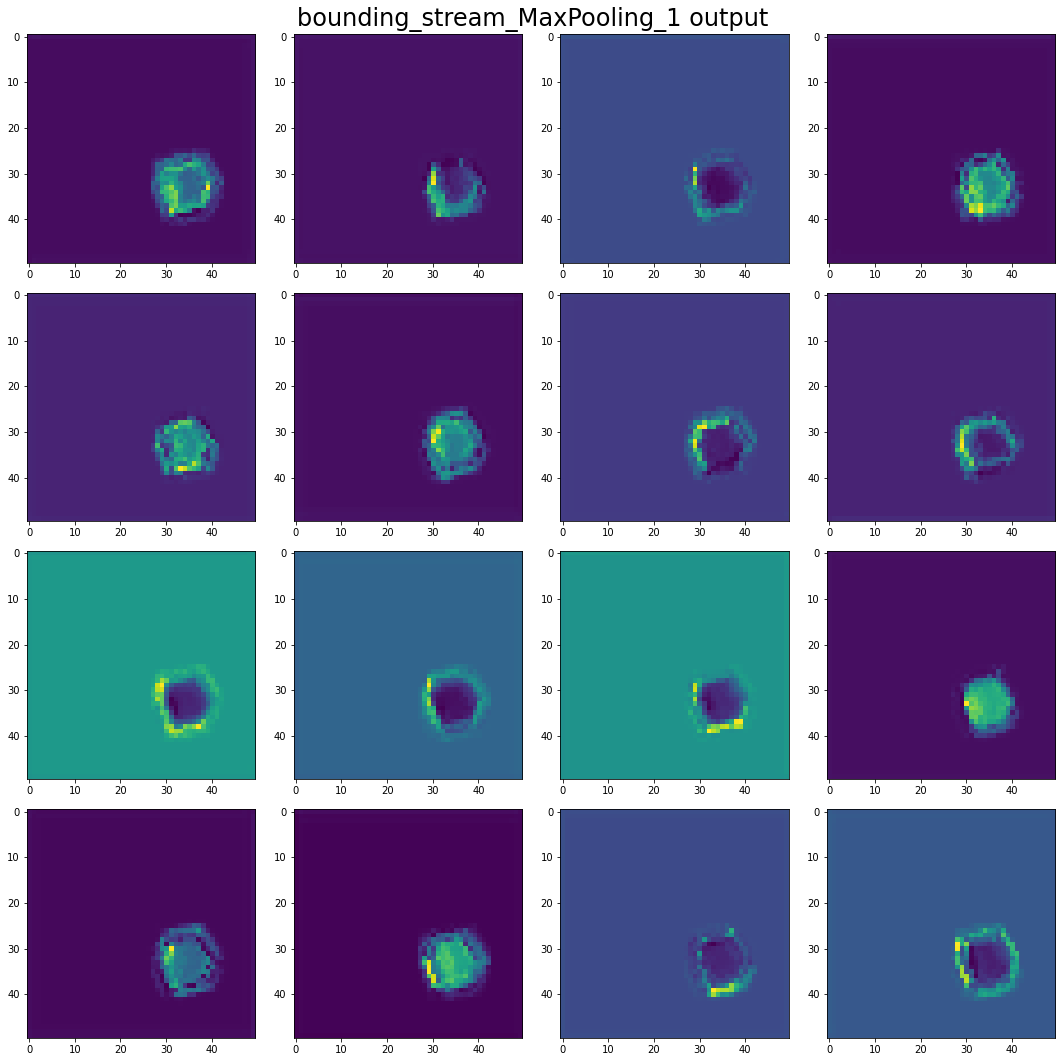

In [15]:
extract_layer_data("bounding_stream_MaxPooling_1")

## Position stream

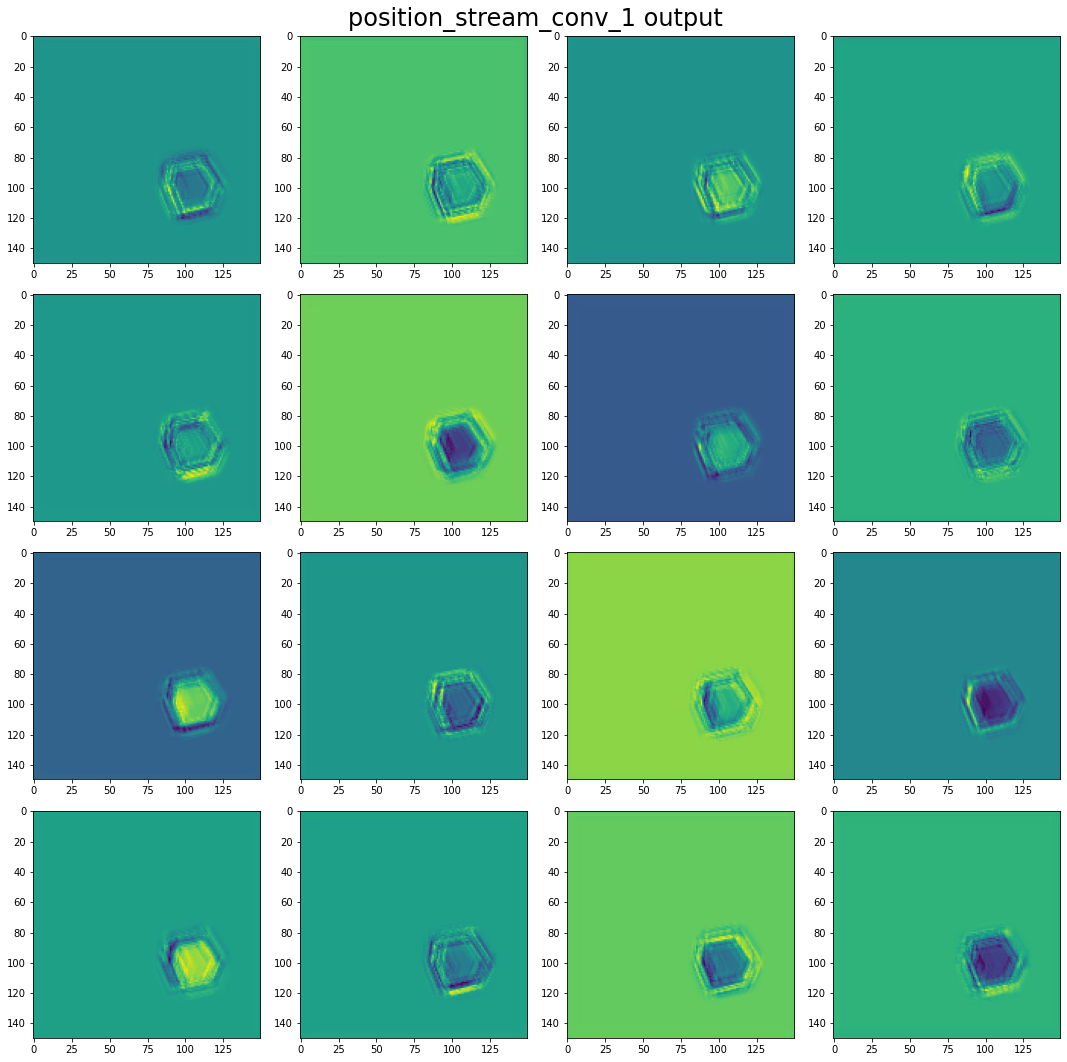

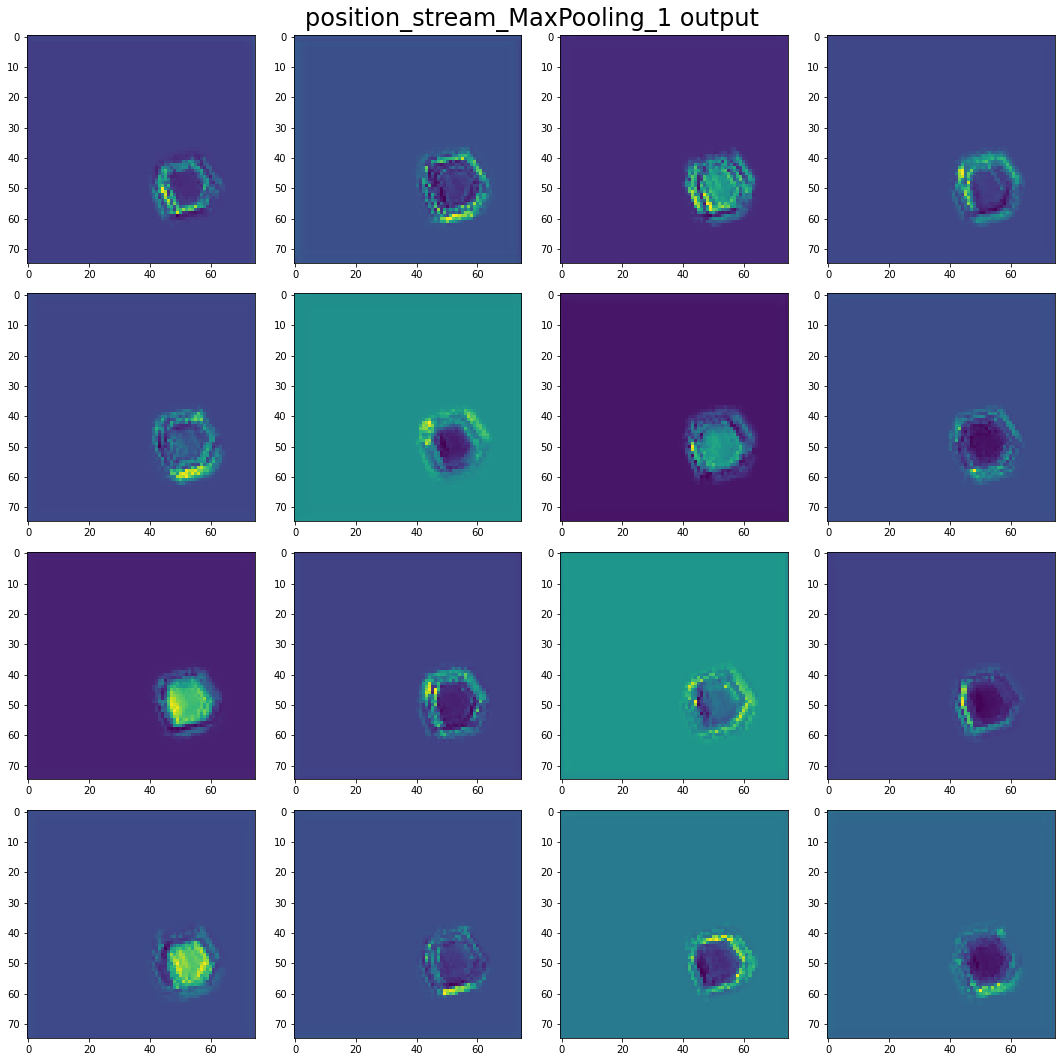

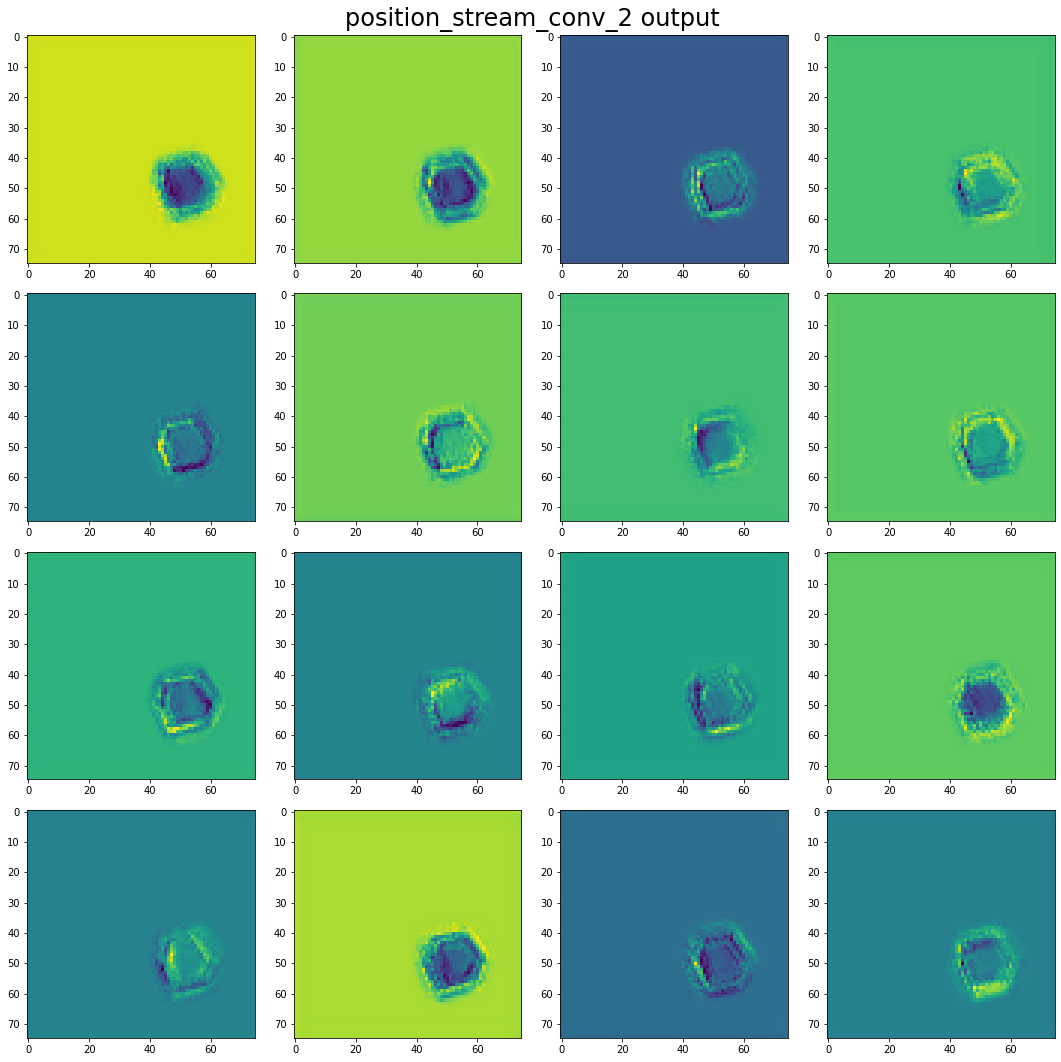

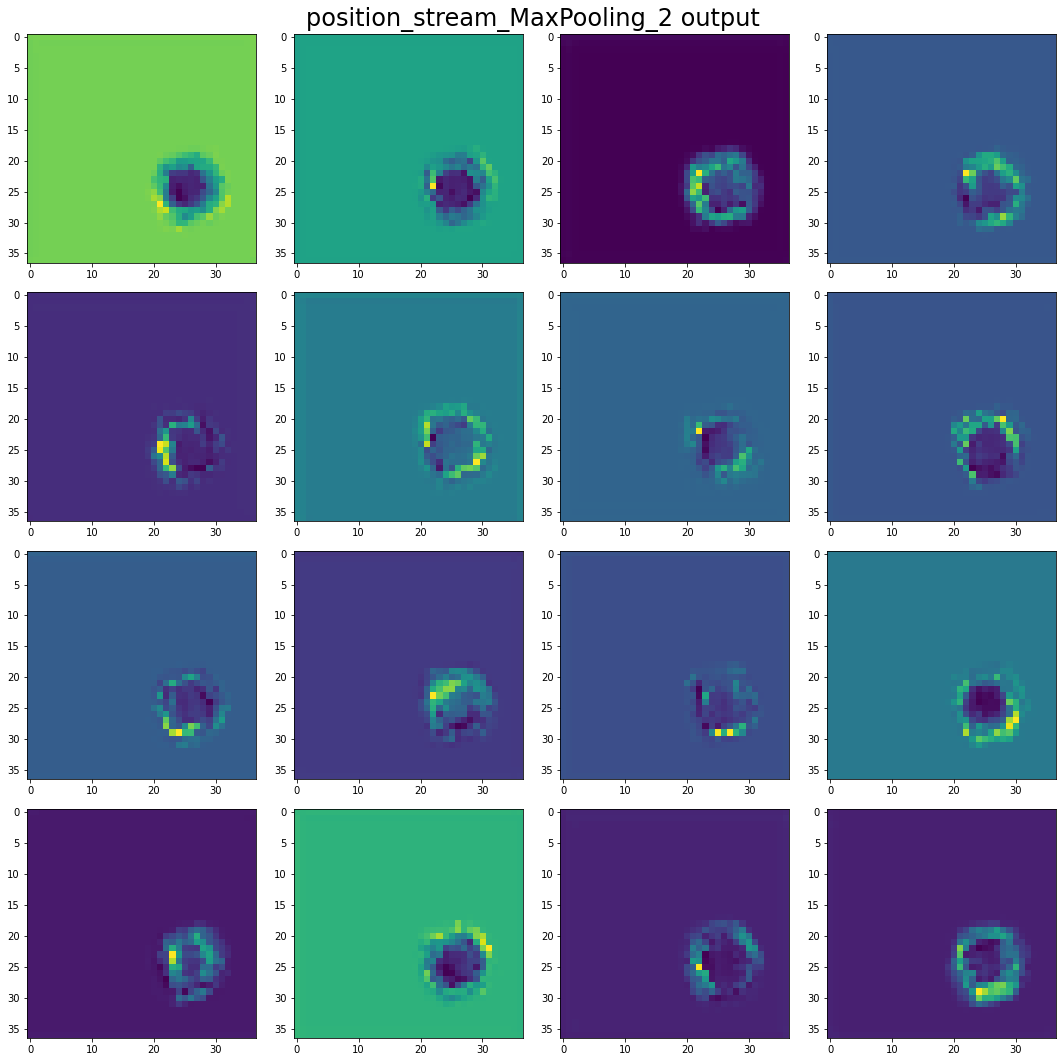

In [16]:
extract_layer_data("position_stream_conv_1")
extract_layer_data("position_stream_MaxPooling_1")
extract_layer_data("position_stream_conv_2")
extract_layer_data("position_stream_MaxPooling_2")

In [16]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")